## import libary

In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.image as mping
import matplotlib.pyplot as plt
import keras
from keras.layers import Input, Dense, Lambda, Conv2D, MaxPooling2D, Activation, Cropping2D, Dropout, Flatten
from keras.models import Sequential,Model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
# def read_csv(csv_pathname):
#     csv_colums = ["center","left","right","steering","throttle","brake","speed"]
#     with open(csv_pathname) as cvsfile:
#         csv_data = pd.read_csv(cvsfile,names=csv_colums)
#     return csv_data  

# csv_data = read_csv("./data/driving_log.csv")
# csv_data.head()

### import images data

In [3]:
def getImagesAngles(csv_path):
    """
    Get center, left, right images and angles from csv_data
    
    Arguments:
        csv_data: CVS data
    Returns:
        centerimages,leftimages,rightimages,angles
    """
    csv_colums = ["center","left","right","steering","throttle","brake","speed"]
    
    # Read CSV file
    with open(csv_path) as cvsfile:
        csv_data = pd.read_csv(cvsfile,names=csv_colums)
    
    # Read images and angles
    headpath = os.path.split(csv_path)[0]
    centerimages = []
    leftimages = []
    rightimages = []
    angles = []
    for c,l,r,a in zip(csv_data["center"],csv_data["left"],csv_data["right"],csv_data["steering"]):
        c_current_path = headpath + '/IMG/' + c.split('\\')[-1] # center images current path
        l_current_path = headpath + '/IMG/' + l.split('\\')[-1] # left images current path
        r_current_path = headpath + '/IMG/' + r.split('\\')[-1] # right images current path
        
        centerimage = mping.imread(c_current_path)
        leftimage = mping.imread(l_current_path)
        rightimage = mping.imread(r_current_path)
        
        centerimages.append(centerimage)
        leftimages.append(leftimage)
        rightimages.append(rightimage)
        angles.append(a)
    
    return csv_data, centerimages, leftimages, rightimages, angles

def combineImagesAngles(centerimages, leftimages, rightimages,angles, correction):
    """
    Combine "center", "left", "right" images using the correction factor "correction"
    
    Returns:
        images, measurements
    """
    images = []
    images.extend(centerimages)
    images.extend(leftimages)
    images.extend(rightimages)
    
    measurements = []
    measurements.extend(angles)
    measurements.extend(x + correction for x in angles) # left image angle move to center, angle is list can not using (angles - correction)
    measurements.extend(x - correction for x in angles) # right image angle move to center
    
    return np.array(images), np.array(measurements)

## Road 1

In [4]:
csv_data1, centerimages1, leftimages1,rightimages1,angles1 = getImagesAngles("./data_run1/driving_log.csv") 
print(np.shape(centerimages1))
print(np.shape(leftimages1))
print(np.shape(rightimages1))
print(np.shape(angles1))
csv_data1.head()

(2491, 160, 320, 3)
(2491, 160, 320, 3)
(2491, 160, 320, 3)
(2491,)


,center,left,right,steering,throttle,brake,speed
0,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,0.0,0.000000,0,11.14113
1,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,0.0,0.000000,0,11.07376
2,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,0.0,0.000000,0,10.98476
3,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,0.0,0.241891,0,11.01884
4,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,D:\DevWorkSpace\Python\CarND-Behavioral-Clonin...,0.0,0.417623,0,11.19517


In [5]:
X_train1, y_train1 = combineImagesAngles(centerimages1, leftimages1, rightimages1, angles1,0.2)
print(X_train1.shape)
print(y_train1.shape)

(7473, 160, 320, 3)
(7473,)


## Road 2 data

In [6]:
csv_data2, centerimages2, leftimages2, rightimages2, angles2 = getImagesAngles("./data_run2/driving_log.csv") 
print(np.shape(centerimages2))
print(np.shape(leftimages2))
print(np.shape(rightimages2))
print(np.shape(angles2))

(4494, 160, 320, 3)
(4494, 160, 320, 3)
(4494, 160, 320, 3)
(4494,)


In [7]:
X_train2, y_train2 = combineImagesAngles(centerimages2, leftimages2,rightimages2,angles2 ,0.2)
print(X_train2.shape)
print(y_train2.shape)

(13482, 160, 320, 3)
(13482,)


## Merge data

In [8]:
X_train = np.concatenate((X_train1, X_train2))
y_train = np.concatenate((y_train1, y_train2))
print(X_train.shape)
print(y_train.shape)

(20955, 160, 320, 3)
(20955,)


### Show left, center and right images

In [9]:
def showviewpoint(leftimages, centerimages, rightimages, angles):
    index = np.random.randint(len(centerimages))
    
    leftimage, centerimage, rightimage = leftimages[index], centerimages[index], rightimages[index]
    l_angle, c_angle, r_angle = angles[index] + 0.2, angles[index], angles[index] - 0.2
    
    plt.figure(figsize=(16, 16))
    plt.subplot(1,3,1)
    plt.imshow(leftimage)
    plt.title('Left Image,steering angle.{:.3f}'.format(l_angle))
    plt.yticks([])
    plt.xticks([])
    
    plt.subplot(1,3,2)
    plt.imshow(centerimage)
    plt.title('Center Image,steering angle.{:.3f}'.format(c_angle))
    plt.yticks([])
    plt.xticks([])
    
    plt.subplot(1,3,3)
    plt.imshow(rightimage)
    plt.title('Right Image ,steering angle.{:.3f}'.format(r_angle))
    plt.yticks([])
    plt.xticks([])

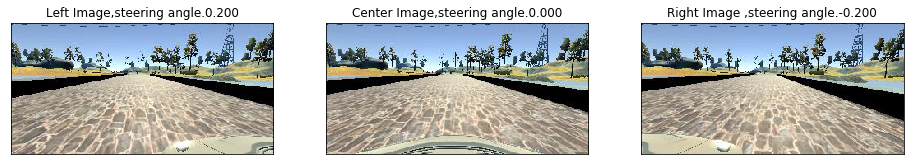

In [10]:
showviewpoint(leftimages1, centerimages1,rightimages1,angles1)

## Augument Data

In [11]:
import cv2
from skimage.util import random_noise

def gamma_correction(image,gamma):
    """
    image Gamma Correction
    x: source img, array like
    gamma: >1 image darken; <1 image brighten
    """
    img = image/255.0
    img = cv2.pow(img,gamma) * 255.0
    # img = img.clip(0,255) # 不会超出范围，因为1的幂还是1
    return img.astype(np.uint8)

def gamma_image(image,angle,gamma=0.8):
    """
    Radomly gamma correction gamma from 0.8-2.8
    """
    # 这里用到了HSV或者HSL的明度通道
    img_cvt = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    img_cvt[:,:,2] = gamma_correction(img_cvt[:,:,2], 2*np.random.sample(1)+gamma)
    return cv2.cvtColor(img_cvt, cv2.COLOR_HSV2RGB),angle
    
def gaussian_blur(image,angle,kernel_size=3):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0),angle    
    
def gaussian_noise(img,angle,mode='gaussian'):
    var = 0.01*np.random.random_sample(1)
    return np.uint8(255*random_noise(img/255.,mode=mode,var=var)),angle

def image_fliplr(image, angle):
    return np.fliplr(image), angle*(-1)
    
def projection_transform(image,angle,hlimit=80,wlimit=80):
    """
    Randomly add projection on image
    
    """
    alpha = np.random.sample(1)
    img_shape = image.shape
    
    height = np.random.randint(0,hlimit)
    weight = np.random.randint(0,wlimit)
    row = np.random.randint(0,img_shape[0]-height) # 最底下进去一个高度，防止出界
    col = np.random.randint(0,img_shape[1]-weight) # 最右边减去一个宽度，防止出界
    result = np.copy(image)
    result[row:row+height,col:col+weight,0] = 128
    result[row:row+height,col:col+weight,1] = 128
    result[row:row+height,col:col+weight,2] = 128
    return result,angle

def image_shift(img,angle, shift_range = 100):
    """
    Shift image and angle horizontally
    """
    w = img.shape[0]
    h = img.shape[1]
    
    shift_x = shift_range*(np.random.uniform(low=0.0, high=1.0) - 0.5)
    shift_y = 0
    M = np.float32([[1,0,shift_x],[0,1,shift_y]])
    image = cv2.warpAffine(img, M, (h,w))
    
    angle = angle + shift_x/w
    return image, angle
    

def augument_images_process(batch_images,batch_angles,gammarate=0.5,blurrate=0.5,projectionrate=0.5,shiftrate=0.4):
    images = []
    angles = []
    for img,angle in tqdm(zip(batch_images,batch_angles),total=len(batch_images)):
        img_ = np.copy(img)
        angle_ = np.copy(angle)
        if(np.random.sample(1) < gammarate):
            img_, angle_ = gamma_image(img_,angle_)
        
        if(np.random.sample(1) < blurrate):
            img_, angle_ = gaussian_blur(img_,angle_)
        
        if(np.random.sample(1) < projectionrate):
            img_, angle_ = projection_transform(img_,angle_)
            
        if(np.random.sample(1) < shiftrate):
            img_, angle_ = image_shift(img_,angle_)
            
        img_, angle_ = gaussian_noise(img_,angle_)
        
        images.append(img_)
        angles.append(angle_)
        
        imgflip,angleflip = image_fliplr(img, angle)
        img_ = imgflip
        angle_ = angleflip
        
        if(np.random.sample(1) < gammarate):
            img_, angle_ = gamma_image(img_,angle_)
        
        if(np.random.sample(1) < blurrate):
            img_, angle_ = gaussian_blur(img_,angle_)
        
        if(np.random.sample(1) < projectionrate):
            img_, angle_ = projection_transform(img_,angle_)
            
        if(np.random.sample(1) < shiftrate):
            img_, angle_ = image_shift(img_,angle_)
            
        img_, angle_ = gaussian_noise(img_,angle_)
        
        images.append(img_)
        angles.append(angle_)
    return np.array(images), np.array(angles)   

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.59it/s]


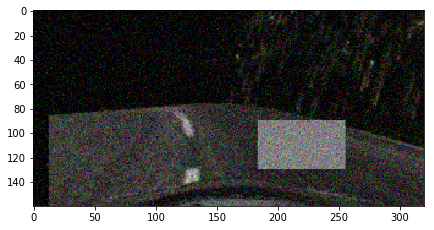

In [12]:
index1 = np.random.randint(len(X_train))
X,y = augument_images_process(X_train[index1:index1+10],y_train[index1:index1+10])
plt.figure(figsize=(7,7))
plt.imshow(X[np.random.randint(10)])

In [13]:
X_train_processed,y_train_processed = augument_images_process(X_train,y_train)

100%|████████████████████████████████████████████████████████████████████████████| 20955/20955 [10:37<00:00, 32.89it/s]


In [14]:
print(X_train_processed.shape)
print(y_train_processed.shape)

(41910, 160, 320, 3)
(41910,)


In [15]:
import pickle

train_dataset_file = "gen_data.p"

pickle.dump({
        "features" : X_train_processed,
        "labels" : y_train_processed
    }, open(train_dataset_file, "wb" ),protocol=4)
print("Generated data saved in", train_dataset_file)

Generated data saved in gen_data.p


In [16]:
import pickle

train_dataset_file = "gen_data.p"

with open(train_dataset_file, mode='rb') as f:
    gen_train = pickle.load(f)
    
X_train, y_train = gen_train['features'], gen_train['labels']
print("Number of training examples after augmenting and balancing training data =", X_train.shape[0])

Number of training examples after augmenting and balancing training data = 41910


In [17]:
# def generator(images, angles, batch_size = 128):
#     """
#     Generate the required images and measurments for taining
#     """
#     num_samples = len(images)
#     while 1: 
#         for offset in range(0,num_samples,batch_size):
#             batch_images = images[offset:offset + batch_size]
#             batch_angles = angles[offset:offset + batch_size]
            
#         inputs = np.array(batch_images)
#         outputs = np.array(batch_angles)
#         yield inputs,outputs

## Model Architecture

In [18]:
x = Input(shape=(160,320,3))
y = Lambda(lambda x: x/250.0 - 0.5)(x)
y = Cropping2D(cropping=((70,25),(0,0)))(y)
y = Conv2D(24,kernel_size=(5,5),strides=(2,2),activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Conv2D(36,kernel_size=(5,5),strides=(2,2),activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Conv2D(48,kernel_size=(5,5),strides=(2,2),activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Conv2D(64,kernel_size=(3,3),activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Conv2D(64,kernel_size=(3,3),activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Dropout(0.5)(y)
y = Flatten()(y)
y = Dense(100,kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Dropout(0.25)(y)
y = Dense(50,kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Dropout(0.25)(y)
y = Dense(10,kernel_regularizer=keras.regularizers.l2(0.0005))(y)
y = Dropout(0.1)(y)
y = Dense(1)(y)
model = Model(inputs=x, outputs=y)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 320, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 35, 64)         27712     
__________

In [19]:
def trainModel(model=model, X_train=X_train, y_train=y_train, batch_size=128, epochs=50, lr=0.0005, patience=10, verbose=1, savefile='./model.h5'):
    adam_optimizer = keras.optimizers.Adam(lr=lr)
    model.compile(optimizer=adam_optimizer,loss=keras.losses.mean_squared_error)
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=patience)
    
    train_history = model.fit(X_train, y_train, batch_size=128, epochs=epochs, verbose=verbose, callbacks=[earlystop], validation_split=0.2, shuffle=True)
    
    model.save(savefile)
    
    # plot the training and validation loss for each epoch
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='best')
    plt.show()

Train on 33528 samples, validate on 8382 samples
Epoch 1/50
 - 46s - loss: 0.2336 - val_loss: 0.2084
Epoch 2/50
 - 37s - loss: 0.1463 - val_loss: 0.1714
Epoch 3/50
 - 37s - loss: 0.1186 - val_loss: 0.1547
Epoch 4/50
 - 37s - loss: 0.1049 - val_loss: 0.1353
Epoch 5/50
 - 37s - loss: 0.0963 - val_loss: 0.1466
Epoch 6/50
 - 37s - loss: 0.0914 - val_loss: 0.1262
Epoch 7/50
 - 37s - loss: 0.0862 - val_loss: 0.1244
Epoch 8/50
 - 36s - loss: 0.0841 - val_loss: 0.1209
Epoch 9/50
 - 37s - loss: 0.0814 - val_loss: 0.1232
Epoch 10/50
 - 37s - loss: 0.0809 - val_loss: 0.1179
Epoch 11/50
 - 37s - loss: 0.0786 - val_loss: 0.1188
Epoch 12/50
 - 37s - loss: 0.0773 - val_loss: 0.1179
Epoch 13/50
 - 37s - loss: 0.0764 - val_loss: 0.1132
Epoch 14/50
 - 37s - loss: 0.0752 - val_loss: 0.1132
Epoch 15/50
 - 37s - loss: 0.0748 - val_loss: 0.1140
Epoch 16/50
 - 37s - loss: 0.0744 - val_loss: 0.1119
Epoch 17/50
 - 37s - loss: 0.0729 - val_loss: 0.1203
Epoch 18/50
 - 37s - loss: 0.0729 - val_loss: 0.1129
Epoch 

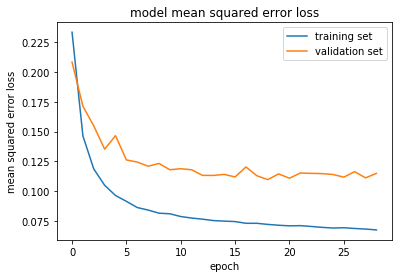

In [20]:
trainModel(model,X_train,y_train,verbose=2)

In [21]:
from keras.models import load_model

def finetuneModel( X_train, y_train, lr=0.0001, verbose=2, loadfile='./model.h5'):
    model = load_model(loadfile)
    trainModel(model,X_train,y_train,lr=lr,verbose=verbose, savefile=loadfile)

Train on 33528 samples, validate on 8382 samples
Epoch 1/50
 - 38s - loss: 0.0607 - val_loss: 0.1075
Epoch 2/50
 - 37s - loss: 0.0590 - val_loss: 0.1073
Epoch 3/50
 - 37s - loss: 0.0576 - val_loss: 0.1086
Epoch 4/50
 - 37s - loss: 0.0572 - val_loss: 0.1085
Epoch 5/50
 - 37s - loss: 0.0566 - val_loss: 0.1082
Epoch 6/50
 - 37s - loss: 0.0565 - val_loss: 0.1074
Epoch 7/50
 - 37s - loss: 0.0561 - val_loss: 0.1063
Epoch 8/50
 - 36s - loss: 0.0551 - val_loss: 0.1073
Epoch 9/50
 - 36s - loss: 0.0549 - val_loss: 0.1070
Epoch 10/50
 - 37s - loss: 0.0549 - val_loss: 0.1070
Epoch 11/50
 - 37s - loss: 0.0539 - val_loss: 0.1090
Epoch 12/50
 - 37s - loss: 0.0543 - val_loss: 0.1064
Epoch 13/50
 - 37s - loss: 0.0537 - val_loss: 0.1080
Epoch 14/50
 - 37s - loss: 0.0532 - val_loss: 0.1091
Epoch 15/50
 - 37s - loss: 0.0533 - val_loss: 0.1097
Epoch 16/50
 - 40s - loss: 0.0532 - val_loss: 0.1088
Epoch 17/50
 - 40s - loss: 0.0525 - val_loss: 0.1089


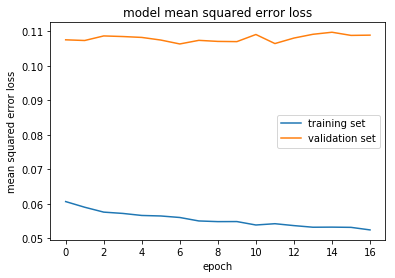

In [22]:
finetuneModel(X_train, y_train, lr=0.0001,verbose=2)